In [1]:
# Bruno Ugolini
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Regressive Tennis T-Test

Use a linear regression and statsmodels to run a t-test on whether Federer scores more points than his opponents in the `tennis.csv` dataset.

Give a one-paragraph interpretation of the coefficient, and the meaning of the p-value. 

Also answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

In [2]:
df = pd.read_csv('Data/tennis.csv')
df = df.dropna(axis=0,subset=['player1 total points won','player2 total points won'],how='any')

<AxesSubplot:xlabel='player2 total points won', ylabel='player1 total points won'>

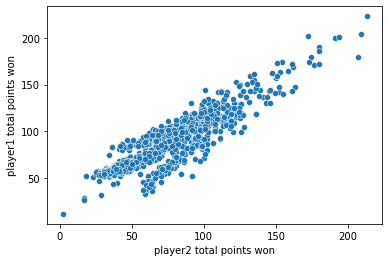

In [3]:
sns.scatterplot(data=df,x='player2 total points won',y='player1 total points won')

In [4]:
x = df['player2 total points won']
y = df['player1 total points won']
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     player1 total points won   R-squared (uncentered):                   0.969
Model:                                  OLS   Adj. R-squared (uncentered):              0.969
Method:                       Least Squares   F-statistic:                          3.196e+04
Date:                      Thu, 14 Jan 2021   Prob (F-statistic):                        0.00
Time:                              10:05:47   Log-Likelihood:                         -4310.3
No. Observations:                      1027   AIC:                                      8623.
Df Residuals:                          1026   BIC:                                      8628.
Df Model:                                 1                                                  
Covariance Type:                  nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
player2 total points won     1.1242      0.006    178.783      0.000       1.112       1.137
==============================================================================
Omnibus:                       72.672   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.996
Skew:                          -0.709   Prob(JB):                     1.29e-19
Kurtosis:                       3.147   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The result shows that Federer does indeed score more points than
his opponents because the slope of the linear regression is 1.1242 +/- 0.006.
We interpret this to mean: for every point made by an opponent, 
Federer scores 1.1242 points (on average).
We note that the t-statistic is large and the p-stat is zero.
More importantly though, we see that the 5% confidence interval
lies completely above 1. So anywhere within the 5% margin Federer
still earns more points than his opponents.

Intuitively, we should not have a constant term since the scores should start at the origin. Adding the constant is equivalent to giving Federer an offset score at the start of the game (y = 0.82 x + 26.3 as shown below). If we adopt this approach we cannot simply look at the slope -which actually decreases below 1 - as was done above. We would need to interpret the constant term as further evidence that Federer's scores always lie above that of the opponent. Federer is so good that it's as if he starts each match with 26.3 more points than his opponents.

In [5]:
est2 = sm.OLS(y, sm.add_constant(x)).fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.794
Model:                                  OLS   Adj. R-squared:                  0.794
Method:                       Least Squares   F-statistic:                     3948.
Date:                      Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                              10:08:50   Log-Likelihood:                -4062.7
No. Observations:                      1027   AIC:                             8129.
Df Residuals:                          1025   BIC:                             8139.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       26.2630      1.042     25.199      0.000      24.218      28.308
player2 total points won     0.8199      0.013     62.836      0.000       0.794       0.846
==============================================================================
Omnibus:                       78.409   Durbin-Watson:                   1.378
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.799
Skew:                          -0.640   Prob(JB):                     2.89e-23
Kurtosis:                       3.888   Cond. No.                         211.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

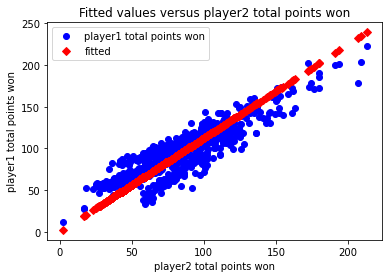

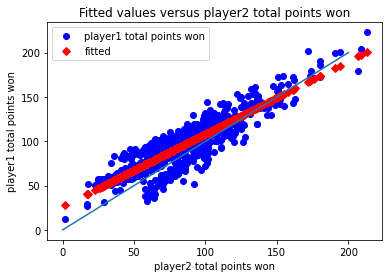

In [7]:
sm.graphics.plot_fit(est, 'player2 total points won', vlines=False)
plt.show()
sm.graphics.plot_fit(est2, 'player2 total points won', vlines=False);
# adding the x = y line for reference to compare with slope
plt.plot([0,200],[0,200])
plt.show()

# 2. College admissions

Using the `college.csv` dataset, answer the following:

1. Is the relation between `Top10perc` and `Top25perc` best fit using a model with only one variable, or one variable and a polynomial of degree 2? Is a constant term useful? How would you select for the best of these model specifications?

2. Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for `Private`. Explain your model specification choices.


<AxesSubplot:xlabel='Top25perc', ylabel='Top10perc'>

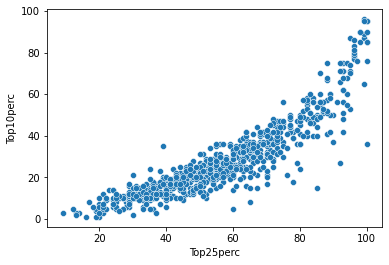

In [8]:
df = pd.read_csv('data/college.csv')
sns.scatterplot(data=df,x='Top25perc',y='Top10perc')

In [11]:
x = df['Top25perc']
y = df['Top10perc']
est_0 = sm.OLS(y, x).fit(cov_type='HC2')
est_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Top10perc   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              4351.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):                   2.12e-320
Time:                        10:15:12   Log-Likelihood:                         -2871.5
No. Observations:                 777   AIC:                                      5745.
Df Residuals:                     776   BIC:                                      5750.
Df Model:                           1                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Top25perc      0.5275      0.008     65.963      0.000       0.512       0.543
==============================================================================
Omnibus:                      308.637   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1351.429
Skew:                           1.814   Prob(JB):                    3.47e-294
Kurtosis:                       8.346   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

In [12]:
df['Top25perc_0'] = 1
x = df[['Top25perc_0','Top25perc']]
y = df['Top10perc']
est_0C = sm.OLS(y, x).fit(cov_type='HC2')
est_0C.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Top10perc   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1310.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):          1.07e-168
Time:                        10:15:35   Log-Likelihood:                -2715.2
No. Observations:                 777   AIC:                             5434.
Df Residuals:                     775   BIC:                             5444.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Top25perc_0   -16.7725      1.074    -15.611      0.000     -18.878     -14.667
Top25perc       0.7945      0.022     36.191      0.000       0.751       0.838
==============================================================================
Omnibus:                       85.585   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              395.735
Skew:                           0.383   Prob(JB):                     1.17e-86
Kurtosis:                       6.411   Cond. No.                         177.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [13]:
df['Top25perc_2'] = df['Top25perc'] * df['Top25perc']

x = df[['Top25perc','Top25perc_2']]
y = df['Top10perc']
est = sm.OLS(y, x).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Top10perc   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              6995.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):                        0.00
Time:                        10:15:57   Log-Likelihood:                         -2600.9
No. Observations:                 777   AIC:                                      5206.
Df Residuals:                     775   BIC:                                      5215.
Df Model:                           2                                                  
Covariance Type:                  HC2                                                  
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Top25perc       0.0974      0.020      4.782      0.000       0.057       0.137
Top25perc_2     0.0062      0.000     18.142      0.000       0.006       0.007
==============================================================================
Omnibus:                      149.322   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              749.525
Skew:                          -0.773   Prob(JB):                    1.75e-163
Kurtosis:                       7.557   Cond. No.                         273.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

In [14]:
x = df[['Top25perc','Top25perc_2','Top25perc_0']]
y = df['Top10perc']
est_c = sm.OLS(y, x).fit(cov_type='HC2')
est_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Top10perc   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1487.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):          8.02e-266
Time:                        10:16:10   Log-Likelihood:                -2578.5
No. Observations:                 777   AIC:                             5163.
Df Residuals:                     774   BIC:                             5177.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Top25perc      -0.3124      0.079     -3.956      0.000      -0.467      -0.158
Top25perc_2     0.0095      0.001     12.377      0.000       0.008       0.011
Top25perc_0    11.7490      1.862      6.310      0.000       8.100      15.398
==============================================================================
Omnibus:                      184.094   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              954.340
Skew:                          -0.970   Prob(JB):                    5.86e-208
Kurtosis:                       8.071   Cond. No.                     3.05e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 3.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

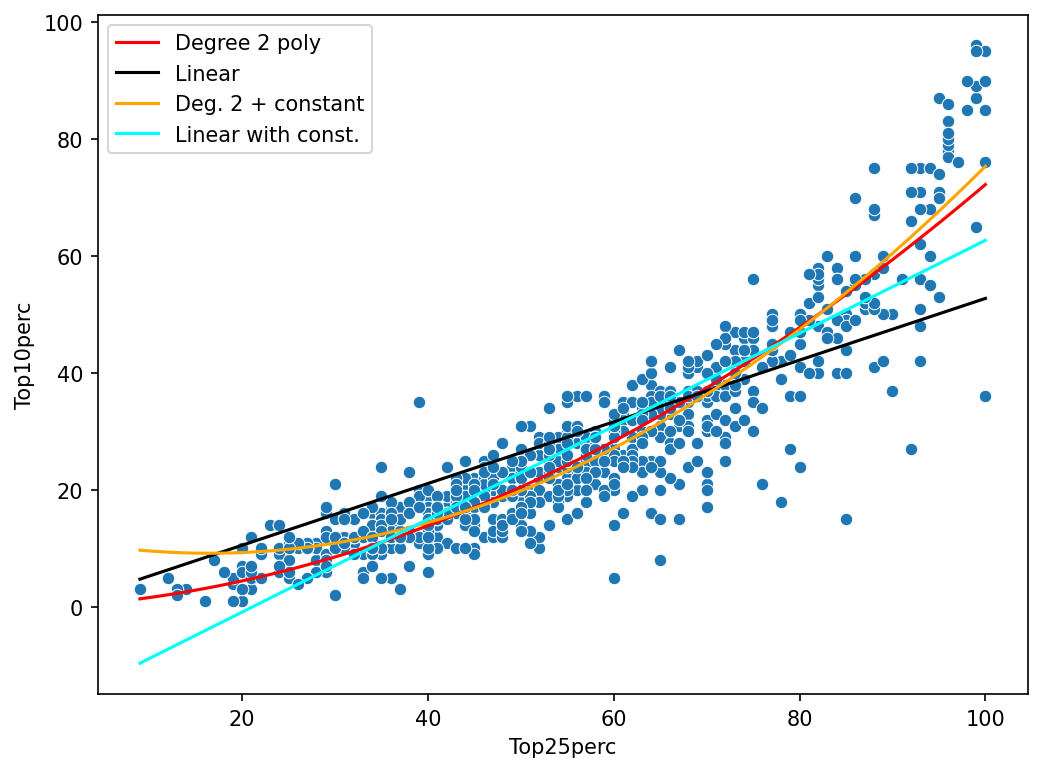

In [16]:
xmin, xmax = (min(df['Top25perc']),max(df['Top25perc']))

xfit0 = np.linspace(xmin, xmax, 1000)
xfit0 = xfit0.reshape((1000,1))

xfit2 = xfit0 * xfit0
xfit = np.concatenate([xfit0, xfit2],axis=1)

fig = plt.figure(dpi=150, figsize=(8,6))
sns.scatterplot(data=df,x='Top25perc',y='Top10perc')

yfit = est.predict(xfit)
plt.plot(xfit[:,0], yfit, color='red',label='Degree 2 poly')

yfit_0 = est_0.predict(xfit[:,0])
plt.plot(xfit[:,0], yfit_0, color='black',label='Linear')

xfitC = xfit0 * 0 + 1
xfit_C = np.concatenate([xfit0, xfit2, xfitC],axis=1)

yfit_C = est_c.predict(xfit_C)
plt.plot(xfit[:,0], yfit_C, color='orange',label='Deg. 2 + constant')

xfit_0C = np.concatenate([xfitC, xfit0],axis=1)

yfit_0C = est_0C.predict(xfit_0C)
plt.plot(xfit[:,0], yfit_0C, color='cyan',label='Linear with const.')


plt.legend();

Is the relation between Top10perc and Top25perc best fit using a model with only one variable, or one variable and a polynomial of degree 2? Is a constant term useful? How would you select for the best of these model specifications?

## Adding a constant to either linear or 2nd degree polynomial degrades the R-squared.

## The single-parameter model has an R-squared of 0.911 while the 2nd degree polynomial has an R-squared of 0.956. The best option appears to be 2nd order polynomial which is also confirmed by the chart aestetics.

In [17]:
df = pd.read_csv('data/college.csv')
df[['Private','Accept','Enroll']]

,Private,Accept,Enroll
0,Yes,1232,721
1,Yes,1924,512
2,Yes,1097,336
3,Yes,349,137
4,Yes,146,55
...,...,...,...
772,No,1515,543
773,Yes,1805,695
774,Yes,1915,695
775,Yes,2453,1317


Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for Private. Explain your model specification choices.

In [19]:
df['Target'] = df['Private'].map({'Yes':1,'No':0})

x = df['Target']
y = df['Enroll']
est = sm.OLS(y, sm.add_constant(x)).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Enroll   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     177.9
Date:                Thu, 14 Jan 2021   Prob (F-statistic):           1.09e-36
Time:                        10:18:33   Log-Likelihood:                -6261.0
No. Observations:                 777   AIC:                         1.253e+04
Df Residuals:                     775   BIC:                         1.254e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1640.8726     86.646     18.938      0.000    1471.049    1810.697
Target     -1183.9275     88.759    -13.339      0.000   -1357.891   -1009.964
==============================================================================
Omnibus:                      421.162   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3666.463
Skew:                           2.310   Prob(JB):                         0.00
Kurtosis:                      12.587   Cond. No.                         3.60
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

<AxesSubplot:xlabel='Target', ylabel='Enroll'>

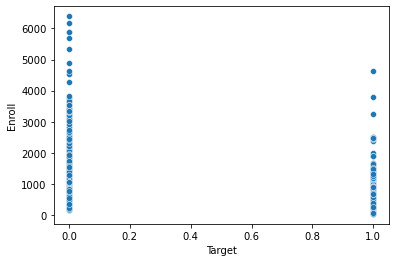

In [20]:
sns.scatterplot(data=df,x='Target',y='Enroll')

In [21]:
pub, priv = (df.loc[df['Target'] < 0.5].Enroll.sum(), df.loc[df['Target'] > 0.5].Enroll.sum())
print(df.Target.sum(), len(df))
print(priv, pub)
347865/(777-565) - 258174 / 565



565 777
258174 347865


1183.9275087660712

## Modelling the private/public schools as binary -1/0 and applying an OLS to 'Enroll' we find a negative "slope" (with significant stats) which indicates that less students are admitted to private schools. 

## How do we interpret this coefficient number: -1184? It represents the increment in admissions on average for a private school vs a public school.

## Private schools: admissions / # of schools = 258174 / 565 = 457
## Public schools: admissions / # of schools = 347865 / (777-565) = 1641
## private - public = 457 - 1641 = -1184

# 3. Auto prediction

Using the `auto.csv` dataset, perform a simple linear regression with `mpg` as the response variable and horsepower as the predictor. Answer the following:

 i. Is there a relationship between the predictor and the response?
 
 ii. How strong is the relationship between the predictor and the response?
 
 iii. Is the relationship between the predictor and the response positive or negative?

 iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals ?

 v. Make a regression plot the response and the predictor.

In [22]:
import re
data_file = open('data/auto.csv', 'r')
with open('data/auto_corrected.csv', 'w') as f:
    for i, line in enumerate(data_file):
        if i == 0:
            line = re.sub(r'\s',',',line,count=4)
            line = re.sub(r'\t',',',line)
            f.write(f"{line}\n")
        elif i == 1:
            pass
        else:
            line = re.sub(r'(?<=[0-9.0-9])\s+(?=["])',',',line)
            line = re.sub(r'(?<=[0-9.0-9\?])\s+(?=[\?0-9.0-9])',',',line)
            line = re.sub('\?','NaN',line)
            f.write(line)
df = pd.read_csv('data/auto_corrected.csv')
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
394,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
395,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

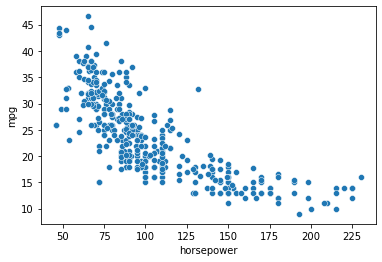

In [23]:
sns.scatterplot(data=df,x='horsepower',y='mpg')

In [25]:
df = df.dropna(subset=['horsepower','mpg'],how='any',axis=0)
df['hp_2'] = df['horsepower'] * df['horsepower']
df = sm.add_constant(df)
X = df[['horsepower','hp_2','const']]
y = df['mpg']

est = sm.OLS(y, X).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     601.3
Date:                Thu, 14 Jan 2021   Prob (F-statistic):          9.66e-120
Time:                        10:21:59   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
horsepower    -0.4662      0.033    -14.029      0.000      -0.531      -0.401
hp_2           0.0012      0.000     10.294      0.000       0.001       0.001
const         56.9001      2.090     27.222      0.000      52.803      60.997
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

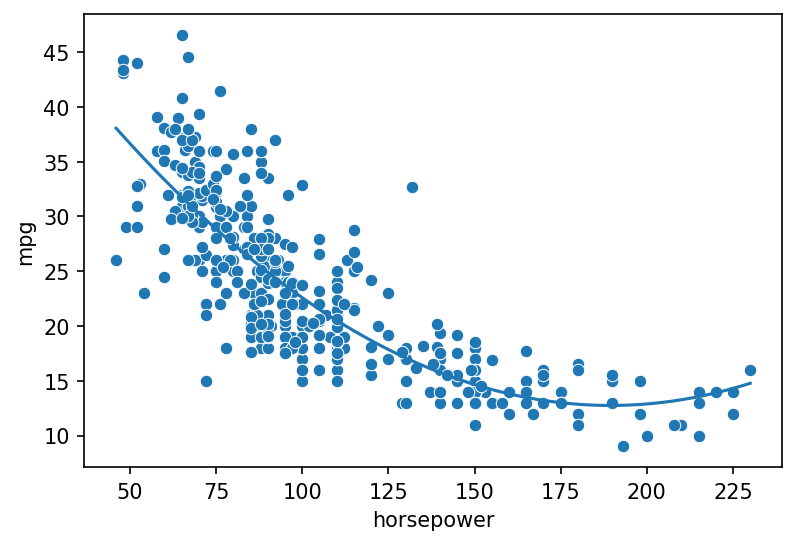

In [26]:
xfit = np.linspace(min(df['horsepower']), max(df['horsepower']), 1000)
xfit = xfit.reshape((1000,1))
xfit2 = xfit * xfit
xfit0 = xfit * 0 + 1
x_fit = np.concatenate([xfit, xfit2, xfit0],axis=1)

y_fit = est.predict(x_fit)
fig = plt.figure(dpi=150, figsize=(6,4))
sns.scatterplot(data=df,x='horsepower',y='mpg')
plt.plot(x_fit[:,0], y_fit)


i. Is there a relationship between the predictor and the response?

## Yes, there is a parabolic relationship (quadratic).

ii. How strong is the relationship between the predictor and the response?

## R-squared (0.688), F-statistic and coefficient statistics all point to a strong relationship between predictor and response.

iii. Is the relationship between the predictor and the response positive or negative?

## They are inversely proportional: the higher the horsepower, the lower the mpg. This could also have been modelled by an inverse relationship.

iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals ?
## (see below)

v. Make a regression plot the response and the predictor.
## (see above)

In [27]:
print(f"The prediction for a horsepower of 98 is: {est.predict([98, 98*98,1])[0]:.3f}.")
res = est.get_prediction([98, 98*98,1])
print(f"The confidence interval is: {res.conf_int()[0][0]:.3f} to {res.conf_int()[0][1]:.3f}.")


The prediction for a horsepower of 98 is: 23.032.
The confidence interval is: 22.558 to 23.505.


# 4. Auto Multiple Regression

Perform a multiple linear regression with `mpg` as the response and all other variables except name in `auto` as the predictors. Comment on the output:

i. Is there a relationship between the predictors and the response?

ii. Which predictors appear to have a statistically significant relationship to the response?

iii. What does the coefficient for the year variable suggest?

iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?

v. Is there heteroscedasticity in the fit?

In [28]:
df = df.drop(['name','const','hp_2'],axis=1)
X = df.drop(columns=['mpg'])
y = df['mpg']

est = sm.OLS(y, X).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    mpg   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              2829.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):                        0.00
Time:                        10:23:42   Log-Likelihood:                         -1030.4
No. Observations:                 392   AIC:                                      2075.
Df Residuals:                     385   BIC:                                      2103.
Df Model:                           7                                                  
Covariance Type:                  HC2                                                  
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.7055      0.295     -2.395      0.017      -1.283      -0.128
displacement     0.0219      0.008      2.598      0.009       0.005       0.038
horsepower      -0.0396      0.013     -2.992      0.003      -0.065      -0.014
weight          -0.0060      0.001     -8.301      0.000      -0.007      -0.005
acceleration    -0.0796      0.115     -0.695      0.487      -0.304       0.145
year             0.5836      0.026     22.193      0.000       0.532       0.635
origin           1.3100      0.275      4.759      0.000       0.770       1.849
==============================================================================
Omnibus:                       46.837   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.015
Skew:                           0.681   Prob(JB):                     2.84e-20
Kurtosis:                       4.912   Cond. No.                     6.00e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
[3] The condition number is large,  6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# i. Is there a relationship between the predictors and the response?
The F-stat and R-squared value indicate that there is a significant relationship between predictors and respone.

# ii. Which predictors appear to have a statistically significant relationship to the response?
All the predictors except 'acceleration' have significant coefficients according to the t-test and p-value of the coefficients.

# iii. What does the coefficient for the year variable suggest?
It suggests that car mileage improves by 0.5836 mpg each year.

# iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?
The fit doesn't seem to catch the inherently non-linear behavior of the data (see fit plots below). The residual plot shows a heavy tail to the right which is a symptom of the non-linearity.
# v. Is there heteroscedasticity in the fit?
There is definitely heteroscedasticity based on the plot of residuals vs. mpg. In other words, there is a marked dependence of the residuals based on the predicted value.

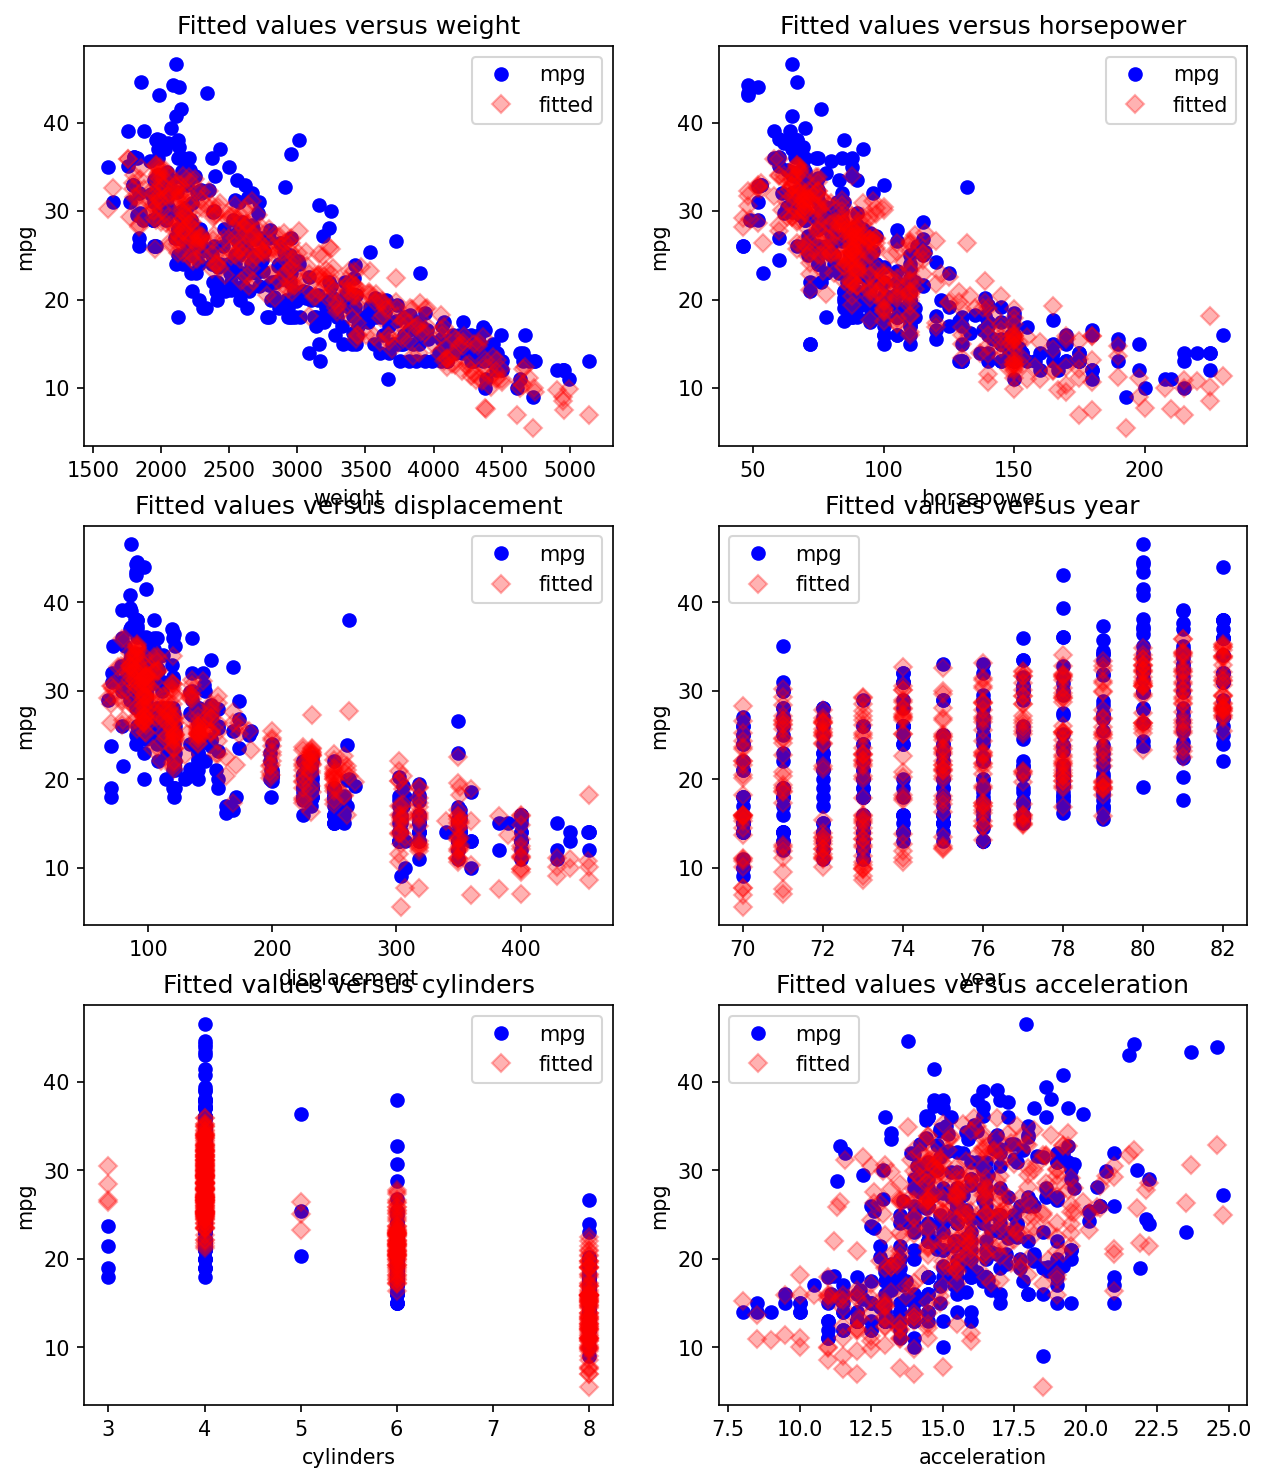

In [29]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,dpi=150, figsize=(10,12))

sm.graphics.plot_fit(est, 'weight', vlines=False,alpha=0.3, ax=ax1);
sm.graphics.plot_fit(est, 'horsepower', vlines=False,alpha=0.3, ax=ax2);
sm.graphics.plot_fit(est, 'displacement', vlines=False,alpha=0.3, ax=ax3);
sm.graphics.plot_fit(est, 'year', vlines=False,alpha=0.3, ax=ax4);
sm.graphics.plot_fit(est, 'cylinders', vlines=False,alpha=0.3, ax=ax5);
sm.graphics.plot_fit(est, 'acceleration', vlines=False,alpha=0.3, ax=ax6);

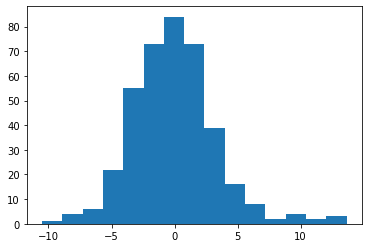

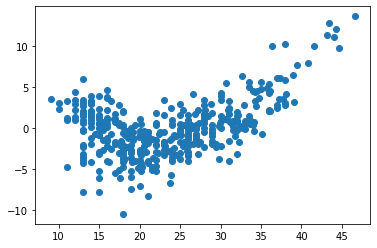

In [30]:
plt.hist(est.resid, bins=15);
plt.show()
ax8 = plt.scatter(df.mpg, est.resid)

# 5. Car Seats

This question should be answered using the Carseats data set

1. Fit a multiple regression model to predict Sales using Price, Urban, and US.

2. Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.

6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

In [31]:
df = pd.read_csv('data/carseats.csv')
df['Urban'] = df['Urban'].map({'Yes':1, 'No':0})
df['US'] = df['US'].map({'Yes':1, 'No':0})
#df

In [32]:
X = df[['Price','Urban','US']]
y = df['Sales']
est = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     43.09
Date:                Thu, 14 Jan 2021   Prob (F-statistic):           4.04e-24
Time:                        10:26:21   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0435      0.641     20.333      0.000      11.786      14.301
Price         -0.0545      0.005    -10.515      0.000      -0.065      -0.044
Urban         -0.0219      0.258     -0.085      0.932      -0.527       0.484
US             1.2006      0.246      4.878      0.000       0.718       1.683
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.758
Skew:                           0.093   Prob(JB):                        0.684
Kurtosis:                       2.897   Cond. No.                         628.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

<Figure size 900x900 with 0 Axes>

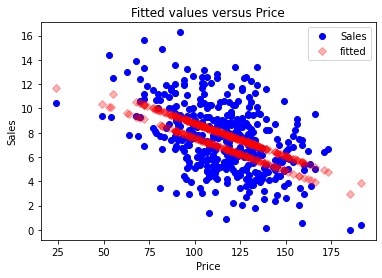

In [33]:
fig = plt.figure(dpi=150, figsize=(6,6))

sm.graphics.plot_fit(est, 'Price', vlines=False,alpha=0.3);

Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!
## Const is the intercept of the fit.
## Price has a negative coefficient indicating: the higher the price, the lower the sales. The slope is -0.055. Sales is in thousands. So, for every dollar increase in price, sales decrease by 55 units.
## Urban is not correlated with the results.
## US is positively correlated to Sales with a slope of 1.2. If a store is located in the US, they sell 1,200 more seats than if not (on average).

For which of the predictors can you reject the null hypothesis H0 : βj = 0?
## Urban is the only predictor for which we CANNOT reject the null hypothesis. So, Price and US and Const we can reject Ho.

In [34]:
X = df[['Price','US']]
y = df['Sales']
est2 = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC2')
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     64.66
Date:                Thu, 14 Jan 2021   Prob (F-statistic):           4.90e-25
Time:                        10:28:25   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0308      0.622     20.944      0.000      11.811      14.250
Price         -0.0545      0.005    -10.543      0.000      -0.065      -0.044
US             1.1996      0.247      4.863      0.000       0.716       1.683
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.749
Skew:                           0.092   Prob(JB):                        0.688
Kurtosis:                       2.895   Cond. No.                         607.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

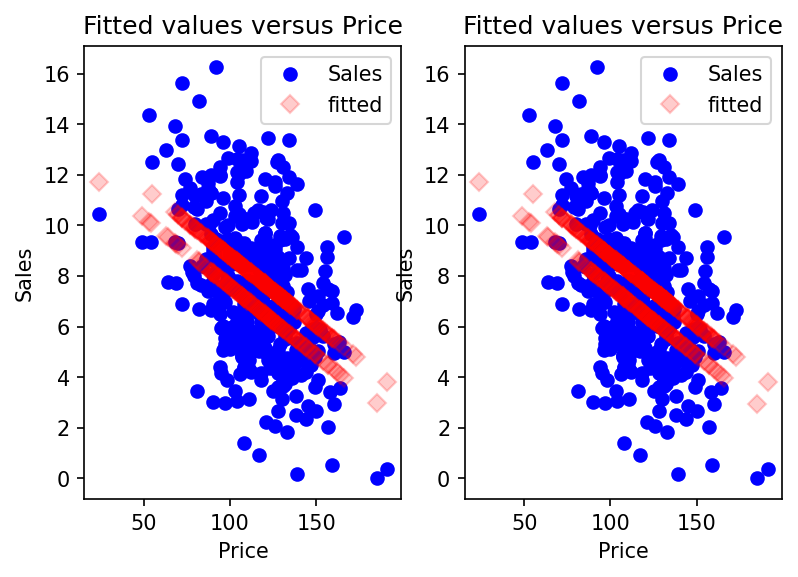

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2,dpi=150, figsize=(6,4))

sm.graphics.plot_fit(est, 'Price', vlines=False,alpha=0.2,ax=ax1);
sm.graphics.plot_fit(est2, 'Price',vlines=False,alpha=0.2,ax=ax2);

On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.
## see above
How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.
## There is barely any perceived change in the fits: noise change in the coefficients of the fit. The AIC, BIC and Adjusted R-squared got a little better.
Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

In [36]:
results_summary = est2.summary()
results_as_html = results_summary.tables[1].as_html()
df_coef = pd.read_html(results_as_html, header=0, index_col=0)[0]
df_coef[['coef','[0.025','0.975]']]

,coef,[0.025,0.975]
const,13.0308,11.811,14.250
Price,-0.0545,-0.065,-0.044
US,1.1996,0.716,1.683
